# Implementing a Recommender System with SageMaker, MXNet, and Gluon
_**Making Video Recommendations Using Neural Networks and Embeddings**_

--- 

---

*This work is based on content from the [Cyrus Vahid's 2017 re:Invent Talk](https://github.com/cyrusmvahid/gluontutorials/blob/master/recommendations/MLPMF.ipynb)*


## Contents

1. [Background](#Background)
1. [Setup](#Setup)
1. [Data](#Data)
  1. [Explore](#Explore)
  1. [Clean](#Clean)
  1. [Prepare](#Prepare)
1. [Train Locally](#Train-Locally)
  1. [Define Network](#Define-Network)
  1. [Set Parameters](#Set-Parameters)
  1. [Execute](#Execute)
1. [Train with SageMaker](#Train-with-SageMaker)
  1. [Wrap Code](#Wrap-Code)
  1. [Move Data](#Move-Data)
  1. [Submit](#Submit)
1. [Host](#Host)
  1. [Evaluate](#Evaluate)
1. [Wrap-up](#Wrap-up)

---

## Background

In many ways, recommender systems were a catalyst for the current popularity of machine learning.  One of Amazon's earliest successes was the "Customers who bought this, also bought..." feature, while the million dollar Netflix Prize spurred research, raised public awareness, and inspired numerous other data science competitions.

Recommender systems can utilize a multitude of data sources and ML algorithms, and most combine various unsupervised, supervised, and reinforcement learning techniques into a holistic framework.  However, the core component is almost always a model which which predicts a user's rating (or purchase) for a certain item based on that user's historical ratings of similar items as well as the behavior of other similar users.  The minimal required dataset for this is a history of user item ratings.  In our case, we'll use 1 to 5 star ratings from over 2M Amazon customers on over 160K digital videos.  More details on this dataset can be found at its [AWS Public Datasets page](https://s3.amazonaws.com/amazon-reviews-pds/readme.html).

Matrix factorization has been the cornerstone of most user-item prediction models.  This method starts with the large, sparse, user-item ratings in a single matrix, where users index the rows, and items index the columns.  It then seeks to find two lower-dimensional, dense matrices which, when multiplied together, preserve the information and relationships in the larger matrix.

![image](https://data-artisans.com/img/blog/factorization.svg)

Matrix factorization has been extended and genarlized with deep learning and embeddings.  These techniques allows us to introduce non-linearities for enhanced performance and flexibility.  This notebook will fit a neural network-based model to generate recommendations for the Amazon video dataset.  It will start by exploring our data in the notebook and even training a model on a sample of the data.  Later we'll expand to the full dataset and fit our model using a SageMaker managed training cluster.  We'll then deploy to an endpoint and check our method.

---

## Setup

_This notebook was created and tested on an ml.p2.xlarge notebook instance._

Let's start by specifying:

- The S3 bucket and prefix that you want to use for training and model data.  This should be within the same region as the Notebook Instance, training, and hosting.
- The IAM role arn used to give training and hosting access to your data. See the documentation for how to create these.  Note, if more than one role is required for notebook instances, training, and/or hosting, please replace the `get_execution_role()` call with the appropriate full IAM role arn string(s).

In [ ]:
bucket = '<your_s3_bucket_name_here>'
prefix = 'sagemaker/DEMO-gluon-recsys'

import sagemaker
role = sagemaker.get_execution_role()

Now let's load the Python libraries we'll need for the remainder of this example notebook.

In [1]:
import os
import mxnet as mx
from mxnet import gluon, nd, ndarray
from mxnet.metric import MSE
import pandas as pd
import numpy as np
import sagemaker
from sagemaker.mxnet import MXNet
import boto3
import json
import matplotlib.pyplot as plt

---
## Data

### Explore

Let's start by bringing in our dataset from an S3 public bucket.  As mentioned above, this contains 1 to 5 star ratings from over 2M Amazon customers on over 160K digital videos.  More details on this dataset can be found at its [AWS Public Datasets page](https://s3.amazonaws.com/amazon-reviews-pds/readme.html).

_Note, because this dataset is over a half gigabyte, the load from S3 may take ~10 minutes.  Also, since Amazon SageMaker Notebooks start with a 5GB persistent volume by default, and we don't need to keep this data on our instance for long, we'll bring it to the temporary volume (which has up to 20GB of storage)._

In [2]:
import sagemaker
from sagemaker import get_execution_role
bucket = 'sagemaker-test-wc'
prefix = 'gluon'


role = sagemaker.get_execution_role()

Let's read the data into a [Pandas DataFrame](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html) so that we can begin to understand it.

*Note, we'll set `error_bad_lines=False` when reading the file in as there appear to be a very small number of records which would create a problem otherwise.*

In [3]:
role = get_execution_role()
data_key = 'gluon/train/ratings_sagemaker.csv'
data_location = 's3://{}/{}'.format(bucket, data_key)

df = pd.read_csv(data_location)

In [4]:
df.head(5)

,customer_id,product_id,star_rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [5]:
df = df[['customer_id', 'product_id', 'star_rating']]

Because most people haven't seen most videos, and people rate fewer videos than we actually watch, we'd expect our data to be sparse.  Our algorithm should work well with this sparse problem in general, but we may still want to clean out some of the long tail.  Let's look at some basic percentiles to confirm.

In [6]:
customers = df['customer_id'].value_counts()
products = df['product_id'].value_counts()


As we can see, only about 5% of customers have rated 5 or more videos, and only 25% of videos have been rated by 9+ customers.

### Clean

Let's filter out this long tail.

In [7]:
reduced_df = df.merge(pd.DataFrame({'customer_id': customers.index})).merge(pd.DataFrame({'product_id': products.index}))

Now, we'll recreate our customer and product lists since there are customers with more than 5 reviews, but all of their reviews are on products with less than 5 reviews (and vice versa).

In [8]:
customers = reduced_df['customer_id'].value_counts()
products = reduced_df['product_id'].value_counts()

Next, we'll number each user and item, giving them their own sequential index.  This will allow us to hold the information in a sparse format where the sequential indices indicate the row and column in our ratings matrix.

In [9]:
customer_index = pd.DataFrame({'customer_id': customers.index, 'user': np.arange(customers.shape[0])})
product_index = pd.DataFrame({'product_id': products.index, 
                              'item': np.arange(products.shape[0])})

reduced_df = reduced_df.merge(customer_index).merge(product_index)
reduced_df.head()

,customer_id,product_id,star_rating,user,item
0,1,1193,5,4131,43
1,2,1193,5,2377,43
2,12,1193,4,5708,43
3,15,1193,4,1576,43
4,17,1193,5,1483,43


### Prepare

Let's start by splitting in training and test sets.  This will allow us to estimate the model's accuracy on videos our customers rated, but wasn't included in our training.

In [10]:
test_df = reduced_df.groupby('customer_id').last().reset_index()

train_df = reduced_df.merge(test_df[['customer_id', 'product_id']], 
                            on=['customer_id', 'product_id'], 
                            how='outer', 
                            indicator=True)
train_df = train_df[(train_df['_merge'] == 'left_only')]

Now, we can convert our Pandas DataFrames into MXNet NDArrays, use those to create a member of the SparseMatrixDataset class, and add that to an MXNet Data Iterator.  This process is the same for both test and control.

In [11]:
batch_size = 1024

train = gluon.data.ArrayDataset(nd.array(train_df['user'].values, dtype=np.float32),
                                nd.array(train_df['item'].values, dtype=np.float32),
                                nd.array(train_df['star_rating'].values, dtype=np.float32))
test  = gluon.data.ArrayDataset(nd.array(test_df['user'].values, dtype=np.float32),
                                nd.array(test_df['item'].values, dtype=np.float32),
                                nd.array(test_df['star_rating'].values, dtype=np.float32))

train_iter = gluon.data.DataLoader(train, shuffle=True, num_workers=4, batch_size=batch_size, last_batch='rollover')
test_iter = gluon.data.DataLoader(train, shuffle=True, num_workers=4, batch_size=batch_size, last_batch='rollover')

---

## Train Locally

### Define Network

Let's start by defining the neural network version of our matrix factorization task.  In this case, our network is quite simple.  The main components are:
- [Embeddings](https://mxnet.incubator.apache.org/api/python/gluon/nn.html#mxnet.gluon.nn.Embedding) which turn our indexes into dense vectors of fixed size.  In this case, 64.
- [Dense layers](https://mxnet.incubator.apache.org/api/python/gluon.html#mxnet.gluon.nn.Dense) with ReLU activation.  Each dense layer has the same number of units as our number of embeddings.  Our ReLU activation here also adds some non-linearity to our matrix factorization.
- [Dropout layers](https://mxnet.incubator.apache.org/api/python/gluon.html#mxnet.gluon.nn.Dropout) which can be used to prevent over-fitting.
- Matrix multiplication of our user matrix and our item matrix to create an estimate of our rating matrix.

In [12]:
class MFBlock(gluon.HybridBlock):
    def __init__(self, max_users, max_items, num_emb, dropout_p=0.5):
        super(MFBlock, self).__init__()
        
        self.max_users = max_users
        self.max_items = max_items
        self.dropout_p = dropout_p
        self.num_emb = num_emb
        
        with self.name_scope():
            self.user_embeddings = gluon.nn.Embedding(max_users, num_emb)
            self.item_embeddings = gluon.nn.Embedding(max_items, num_emb)
            
            self.dropout_user = gluon.nn.Dropout(dropout_p)
            self.dropout_item = gluon.nn.Dropout(dropout_p)

            self.dense_user   = gluon.nn.Dense(num_emb, activation='relu')
            self.dense_item = gluon.nn.Dense(num_emb, activation='relu')
            
    def hybrid_forward(self, F, users, items):
        a = self.user_embeddings(users)
        a = self.dense_user(a)
        
        b = self.item_embeddings(items)
        b = self.dense_item(b)

        predictions = self.dropout_user(a) * self.dropout_item(b)     
        predictions = F.sum(predictions, axis=1)
        return predictions

In [13]:
num_embeddings = 64

net = MFBlock(max_users=customer_index.shape[0], 
              max_items=product_index.shape[0],
              num_emb=num_embeddings,
              dropout_p=0.5)


### Set Parameters

Let's initialize network weights and set our optimization parameters.

In [14]:
# Initialize network parameters
ctx = mx.cpu()
net.collect_params().initialize(mx.init.Xavier(magnitude=60),
                                ctx=ctx,
                                force_reinit=True)
net.hybridize()

# Set optimization parameters
opt = 'sgd'
lr = 0.02
momentum = 0.9
wd = 0.

trainer = gluon.Trainer(net.collect_params(),
                        opt,
                        {'learning_rate': lr,
                         'wd': wd,
                         'momentum': momentum})

### Execute

Let's define a function to carry out the training of our neural network.

In [15]:
def execute(train_iter, test_iter, net, epochs, ctx):
    
    loss_function = gluon.loss.L2Loss()
    for e in range(epochs):
        
        print("epoch: {}".format(e))
        
        for i, (user, item, label) in enumerate(train_iter):
                user = user.as_in_context(ctx)
                item = item.as_in_context(ctx)
                label = label.as_in_context(ctx)
                
                with mx.autograd.record():
                    output = net(user, item)               
                    loss = loss_function(output, label)
                    
                loss.backward()
                trainer.step(batch_size)

        print("EPOCH {}: MSE ON TRAINING and TEST: {}. {}".format(e,
                                                                   eval_net(train_iter, net, ctx, loss_function),
                                                                   eval_net(test_iter, net, ctx, loss_function)))
    print("end of training")
    return net

Let's also define a function which evaluates our network on a given dataset.  This is called by our `execute` function above to provide mean squared error values on our training and test datasets.

In [16]:
def eval_net(data, net, ctx, loss_function):
    acc = MSE()
    for i, (user, item, label) in enumerate(data):
        
            user = user.as_in_context(ctx)
            item = item.as_in_context(ctx)
            label = label.as_in_context(ctx)
            predictions = net(user, item).reshape((batch_size, 1))
            acc.update(preds=[predictions], labels=[label])
   
    return acc.get()[1]

Now, let's train for a few epochs.

In [17]:
%%time

epochs = 3

trained_net = execute(train_iter, test_iter, net, epochs, ctx)

epoch: 0
EPOCH 0: MSE ON TRAINING and TEST: 1.1989251252428756. 1.1990698955722692
epoch: 1
EPOCH 1: MSE ON TRAINING and TEST: 1.0789494939248176. 1.078927003269215
epoch: 2
EPOCH 2: MSE ON TRAINING and TEST: 0.996950554614455. 0.9970031707834387
end of training
CPU times: user 3min 45s, sys: 3.63 s, total: 3min 48s
Wall time: 3min 31s


#### Early Validation

We can see our training error going down, but our validation accuracy bounces around a bit.  Let's check how our model is predicting for an individual user.  We could pick randomly, but for this case, let's try user #6.

In [18]:
product_index['u6_predictions'] = trained_net(nd.array([6] * product_index.shape[0]).as_in_context(ctx), 
                                              nd.array(product_index['item'].values).as_in_context(ctx)).asnumpy()
product_index.sort_values('u6_predictions', ascending=False)

,item,product_id,u6_predictions
3613,3613,3647,4.534433
3548,3548,1905,4.328877
3360,3360,1532,4.322484
3699,3699,1714,4.199345
3526,3526,572,4.171098
3519,3519,827,4.131466
3099,3099,197,4.129376
3484,3484,744,4.061161
3466,3466,3522,4.032640
3623,3623,658,4.030008


Now let's compare this to the predictions for another user (we'll try user #7).

In [19]:
product_index['u7_predictions'] = trained_net(nd.array([7] * product_index.shape[0]).as_in_context(ctx), 
                                              nd.array(product_index['item'].values).as_in_context(ctx)).asnumpy()
product_index.sort_values('u7_predictions', ascending=False)

,item,product_id,u6_predictions,u7_predictions
3548,3548,1905,4.328877,4.675824
3613,3613,3647,4.534433,4.503952
3543,3543,887,3.834744,4.489244
3526,3526,572,4.171098,4.469326
3466,3466,3522,4.032640,4.422765
3699,3699,1714,4.199345,4.302065
3452,3452,1877,3.977762,4.295789
3449,3449,3314,3.967001,4.262650
3416,3416,3205,3.830016,4.211958
3360,3360,1532,4.322484,4.187609


The predicted ratings are different between the two users, but the same top (and bottom) items for user #6 appear for #7 as well.  Let's look at the correlation across the full set of 38K items to see if this relationship holds.

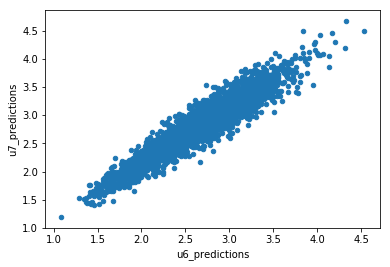

In [20]:
product_index[['u6_predictions', 'u7_predictions']].plot.scatter('u6_predictions', 'u7_predictions')
plt.show()

We can see that this correlation is nearly perfect.  Essentially the average rating of items dominates across users and we'll recommend the same well-reviewed items to everyone.  As it turns out, we can add more embeddings and this relationship will go away since we're better able to capture differential preferences across users.

However, with just a 64 dimensional embedding, it took 7 minutes to run just 3 epochs.  If we ran this outside of our Notebook Instance we could run larger jobs and move on to other work would improve productivity.

---

## Train with SageMaker

Now that we've trained on this smaller dataset, we can expand training in SageMaker's distributed, managed training environment.

### Wrap Code

To use SageMaker's pre-built MXNet container, we'll need to wrap our code from above into a Python script.  There's a great deal of flexibility in using SageMaker's pre-built containers, and detailed documentation can be found [here](https://github.com/aws/sagemaker-python-sdk#mxnet-sagemaker-estimators), but for our example, it consisted of:
1. Wrapping all data preparation into a `prepare_train_data` function (we could name this whatever we like)
1. Copying and pasting classes and functions from above word-for-word
1. Defining a `train` function that:
  1. Adds a bit of new code to pick up the input TSV dataset on the SageMaker Training cluster
  1. Takes in a dict of hyperparameters (which we specified as globals above)
  1. Creates the net and executes training

In [21]:
!cat recommender_test_2.py

import logging
import json
import time
import os
import mxnet as mx
from mxnet import gluon, nd, ndarray
from mxnet.metric import MSE
import numpy as np

os.system('pip install pandas')
import pandas as pd

logging.basicConfig(level=logging.DEBUG)

#########
# Globals
#########

batch_size = 1024


##########
# Training
##########

def train(channel_input_dirs, hyperparameters, hosts, num_gpus, **kwargs):
    
    # get data
    training_dir = channel_input_dirs['train']
    train_iter, test_iter, customer_index, product_index = prepare_train_data(training_dir)
    
    # get hyperparameters
    num_embeddings = hyperparameters.get('num_embeddings', 64)
    opt = hyperparameters.get('opt', 'sgd')
    lr = hyperparameters.get('lr', 0.02)
    momentum = hyperparameters.get('momentum', 0.9)
    wd = hyperparameters.get('wd', 0.)
    epochs = hyperparameters.get('epochs', 5)

    # define net
    ctx = mx.cpu()

    net = MFBlock(max_users=customer_index.shape[0], 
                  max_it

### Test Locally

Now we can test our train function locally.  This helps ensure we don't have any bugs before submitting our code to SageMaker's pre-built MXNet container.

In [ ]:
# %%time

# import recommender

# local_test_net, local_customer_index, local_product_index = recommender.train(
#     {'train': '/tmp/recsys/'}, 
#     {'num_embeddings': 64, 
#      'opt': 'sgd', 
#      'lr': 0.02, 
#      'momentum': 0.9, 
#      'wd': 0.,
#      'epochs': 3},
#     ['local'],
#     1)

### Move Data

Holding our data in memory works fine when we're interactively exploring a sample of data, but for larger, longer running processes, we'd prfer to run them in the background with SageMaker Training.  To do this, let's move the dataset to S3 so that it can be picked up by SageMaker training.  This is perfect for use cases like periodic re-training, expanding to a larger dataset, or moving production workloads to larger hardware.

In [ ]:
#boto3.client('s3').copy({'Bucket': 'amazon-reviews-pds', 
#                         'Key': 'tsv/amazon_reviews_us_Digital_Video_Download_v1_00.tsv.gz'},
#                        bucket,
#                        prefix + '/train/amazon_reviews_us_Digital_Video_Download_v1_00.tsv.gz')

### Submit

Now, we can create an MXNet estimator from the SageMaker Python SDK.  To do so, we need to pass in:
1. Instance type and count for our SageMaker Training cluster.  SageMaker's MXNet containers support distributed GPU training, so we could easily set this to multiple ml.p2 or ml.p3 instances if we wanted.
  - *Note, this would require some changes to our recommender.py script as we would need to setup the context an key value store properly, as well as determining if and how to distribute the training data.*
1. An S3 path for out model artifacts and a role with access to S3 input and output paths.
1. Hyperparameters for our neural network.  Since with a 64 dimensional embedding, our recommendations reverted too closely to the mean, let's increase this by an order of magnitude when we train outside of our local instance.  We'll also increase the epochs to see how our accuracy evolves over time. We'll leave all other hyperparameters the same.

Once we use `.fit()` this creates a SageMaker Training Job that spins up instances, loads the appropriate packages and data, runs our `train` function from `recommender.py`, wraps up and saves model artifacts to S3, and finishes by tearing down the cluster.

In [22]:
m = MXNet('recommender_test_2.py', 
          py_version='py3',
          role=role, 
          train_instance_count=1, 
          train_instance_type="ml.p2.xlarge",
          output_path='s3://{}/{}/output'.format(bucket, prefix),
          hyperparameters={'num_embeddings': 512, 
                           'opt': opt, 
                           'lr': lr, 
                           'momentum': momentum, 
                           'wd': wd,
                           'epochs': 10},
         framework_version='1.1')

m.fit({'train': 's3://{}/{}/train/'.format(bucket, prefix)})

INFO:sagemaker:Created S3 bucket: sagemaker-us-east-1-823715915892
INFO:sagemaker:Creating training-job with name: sagemaker-mxnet-2018-12-10-02-52-40-970


2018-12-10 02:52:41 Starting - Starting the training job...
2018-12-10 02:52:43 Starting - Launching requested ML instances......
2018-12-10 02:53:47 Starting - Preparing the instances for training......
2018-12-10 02:55:08 Downloading - Downloading input data...
2018-12-10 02:55:37 Training - Downloading the training image.....
2018-12-10 02:56:15,971 INFO - root - running container entrypoint
2018-12-10 02:56:15,971 INFO - root - starting train task
2018-12-10 02:56:15,990 INFO - container_support.training - Training starting
2018-12-10 02:56:18,610 INFO - mxnet_container.train - MXNetTrainingEnvironment: {'resource_config': {'hosts': ['algo-1'], 'current_host': 'algo-1', 'network_interface_name': 'ethwe'}, 'enable_cloudwatch_metrics': False, '_ps_verbose': 0, 'container_log_level': 20, 'hyperparameters': {'lr': 0.02, 'sagemaker_region': 'us-east-1', 'sagemaker_submit_directory': 's3://sagemaker-us-east-1-823715915892/sagemaker-mxnet-2018-12-10-02-52-40-970/source/sourcedir.tar.gz', 

---

## Host

Now that we've trained our model, deploying it to a real-time, production endpoint is easy.

In [23]:
predictor = m.deploy(initial_instance_count=1, 
                     instance_type='ml.m4.xlarge')
predictor.serializer = None

INFO:sagemaker:Creating model with name: sagemaker-mxnet-2018-12-10-02-52-40-970
INFO:sagemaker:Creating endpoint with name sagemaker-mxnet-2018-12-10-02-52-40-970


---------------------------------------------------------------!

Now that we have an endpoint, let's test it out.  We'll predict user #6's ratings for the top and bottom ASINs from our local model.

*This could be done by sending HTTP POST requests from a separate web service, but to keep things easy, we'll just use the `.predict()` method from the SageMaker Python SDK.*

In [25]:
predictor.predict(json.dumps({'customer_id': customer_index[customer_index['user'] == 6]['customer_id'].values.tolist(), 
                              'product_id': [3613, 3548]}))

[3.3196239471435547, 2.863354206085205]

In [37]:
list(range(11, 17))

[11, 12, 13, 14, 15, 16]

In [39]:
predictor.predict(json.dumps({'customer_id': customer_index[customer_index['user'] == 6]['customer_id'].values.tolist(),
                             'product_id':list(range(0,3000))}))

[3.265327215194702,
 2.8325424194335938,
 2.378007411956787,
 2.158130168914795,
 1.8588508367538452,
 2.064333200454712,
 3.1149203777313232,
 2.7032158374786377,
 2.510226249694824,
 1.9703006744384766,
 2.8063013553619385,
 3.330688714981079,
 1.7892632484436035,
 3.20155930519104,
 2.5401034355163574,
 2.340268850326538,
 2.8443186283111572,
 3.2755870819091797,
 2.729722261428833,
 2.3734848499298096,
 2.329993724822998,
 2.6018197536468506,
 2.260087251663208,
 2.3417444229125977,
 2.572028875350952,
 2.6176555156707764,
 2.673621892929077,
 2.4263052940368652,
 3.187283515930176,
 3.190189838409424,
 2.7514772415161133,
 2.858943462371826,
 3.339454174041748,
 2.936739206314087,
 3.371976137161255,
 2.9346840381622314,
 2.8738186359405518,
 2.9037444591522217,
 1.8383561372756958,
 2.9336671829223633,
 3.898113489151001,
 3.0374293327331543,
 2.6557679176330566,
 3.13411021232605,
 2.2900960445404053,
 2.3741915225982666,
 2.053189754486084,
 3.545484781265259,
 2.64368200302124

*Note, some of our predictions are actually greater than 5, which is to be expected as we didn't do anything special to account for ratings being capped at that value.  Since we are only looking to ranking by predicted rating, this won't create problems for our specific use case.*

### Evaluate

Let's start by calculating a naive baseline to approximate how well our model is doing.  The simplest estimate would be to assume every user item rating is just the average rating over all ratings.

*Note, we could do better by using each individual video's average, however, in this case it doesn't really matter as the same conclusions would hold.*

In [26]:
print('Naive MSE:', np.mean((test_df['star_rating'] - np.mean(train_df['star_rating'])) ** 2))

Naive MSE: 1.6737109919841058


Now, we'll calculate predictions for our test dataset.

*Note, this will align closely to our CloudWatch output above, but may differ slightly due to skipping partial mini-batches in our eval_net function.*

In [40]:
test_preds = []
for array in np.array_split(test_df[['customer_id', 'product_id']].values, 40):
    test_preds += predictor.predict(json.dumps({'customer_id': array[:, 0].tolist(), 
                                                'product_id': array[:, 1].tolist()}))

test_preds = np.array(test_preds)
print('MSE:', np.mean((test_df['star_rating'] - test_preds) ** 2))

MSE: 1.3479642876799973


We can see that our neural network and embedding model produces substantially better results (~1.27 vs 1.65 on mean square error).

For recommender systems, subjective accuracy also matters.  Let's get some recommendations for a random user to see if they make intuitive sense.

In [41]:
reduced_df[reduced_df['user'] == 6].sort_values(['star_rating', 'item'], ascending=[False, True])

,customer_id,product_id,star_rating,user,item
136535,3618,593,5,6,9
190544,3618,858,5,6,24
219754,3618,50,5,6,38
600199,3618,1304,5,6,80
340827,3618,1358,5,6,135
505978,3618,2324,5,6,143
453750,3618,1234,5,6,187
16115,3618,1035,5,6,269
612908,3618,1947,5,6,345
591457,3618,899,5,6,352


As we can see, user #6 seems to like sprawling dramamtic television series and sci-fi, but they dislike silly comedies.

Now we'll loop through and predict user #6's ratings for every common video in the catalog, to see which ones we'd recommend and which ones we wouldn't.

In [43]:
predictions = []
for array in np.array_split(product_index['product_id'].values, 40):
    predictions += predictor.predict(json.dumps({'customer_id': customer_index[customer_index['user'] == 6]['customer_id'].values.tolist() * array.shape[0], 
                                                 'product_id': array.tolist()}))

predictions = pd.DataFrame({'product_id': product_index['product_id'],
                            'prediction': predictions})

Indeed, our predicted highly rated shows have some well-reviewed TV dramas and some sci-fi.  Meanwhile, our bottom rated shows include goofball comedies.

*Note, because of random initialization in the weights, results on subsequent runs may differ slightly.*

Let's confirm that we no longer have almost perfect correlation in recommendations with user #7.

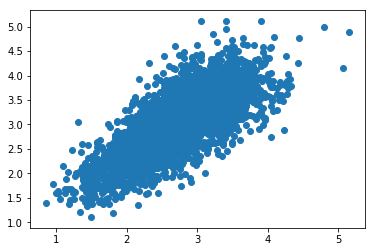

In [44]:
predictions_user7 = []
for array in np.array_split(product_index['product_id'].values, 40):
    predictions_user7 += predictor.predict(json.dumps({'customer_id': customer_index[customer_index['user'] == 7]['customer_id'].values.tolist() * array.shape[0], 
                                                       'product_id': array.tolist()}))
plt.scatter(predictions['prediction'], np.array(predictions_user7))
plt.show()

---

## Wrap-up

In this example, we developed a deep learning model to predict customer ratings.  This could serve as the foundation of a recommender system in a variety of use cases.  However, there are many ways in which it could be improved.  For example we did very little with:
- hyperparameter tuning
- controlling for overfitting (early stopping, dropout, etc.)
- testing whether binarizing our target variable would improve results
- including other information sources (video genres, historical ratings, time of review)
- adjusting our threshold for user and item inclusion 

In addition to improving the model, we could improve the engineering by:
- Setting the context and key value store up for distributed training
- Fine tuning our data ingestion (e.g. num_workers on our data iterators) to ensure we're fully utilizing our GPU
- Thinking about how pre-processing would need to change as datasets scale beyond a single machine

Beyond that, recommenders are a very active area of research and techniques from active learning, reinforcement learning, segmentation, ensembling, and more should be investigated to deliver well-rounded recommendations.

### Clean-up (optional)

Let's finish by deleting our endpoint to avoid stray hosting charges.

In [45]:
sagemaker.Session().delete_endpoint(predictor.endpoint)

INFO:sagemaker:Deleting endpoint with name: sagemaker-mxnet-2018-12-10-02-52-40-970
